# 複数量子ビット

In [2]:
from qiskit import assemble, pulse, QuantumCircuit,\
                   schedule, transpile
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
from qiskit.transpiler import CouplingMap
import numpy as np

これまでは1つの量子ビットに関して考えましたが，量子で計算を行う時は基本的に複数の量子ビットを使用して計算します．このセクションでは複数の量子ビットに関して考えていきます．

## 複数量子ビットの表現方法
$2$個の量子ビットがあった時，すべての量子ビットの測定を行うと
\begin{align}
(1量子ビット目):0 &\quad (2量子ビット目):0\\
(1量子ビット目):1 &\quad (2量子ビット目):0\\
(1量子ビット目):0 &\quad (2量子ビット目):1\\
(1量子ビット目):1 &\quad (2量子ビット目):1
\end{align}
の$4$通りのどれかが得られます．$n$個の量子ビットがあった時は同様にして考えると$2^n$通りの組み合わせが考えられます．<br>
そこで，それぞれ測定から得られる状態を
\begin{align}
(1量子ビット目が1,他の量子ビットはすべて0)&: \quad|100\cdots 00\rangle\\
(2量子ビット目が1,他の量子ビットはすべて0)&:\quad |010\cdots 00\rangle\\
&\vdots
\end{align}
などと量子ビットを対応させて表記すると，これらの$2^n$通りを重ね合わせることができ，$n$量子ビットの量子状態は
\begin{align}
|\psi\rangle = c_{0}|00\cdots 0\rangle + c_{1}|00\cdots 01\rangle + \cdots + c_{2^n-1}|11\cdots 1\rangle
\end{align}
のように$2^n$個の複素数を用いて表すことができます．これらの係数も1量子ビットと同様に**複素振幅**と言います．もちろん規格化条件より
\begin{align}
1 = |c_0|^2 + |c_1|^2+ \cdots +|c_{2^n-1}|^2
\end{align}
を満たしています．また，正規直交条件を満たすような行列の具体的な形は
\begin{align}
|00\cdots 0\rangle =
\begin{bmatrix}
1 \\
0\\
\vdots\\
0
\end{bmatrix},\quad
|00\cdots 01\rangle =
\begin{bmatrix}
0 \\
1\\
\vdots\\
0
\end{bmatrix},\quad
\cdots
\end{align}
であり，全体の波動関数は
\begin{align}
|\psi\rangle =
\begin{bmatrix}
c_0\\
c_1\\
\vdots\\
c_{2^n-1}
\end{bmatrix}
\end{align}
となります．なおこれらの$|00\cdots 0\rangle$などは複数量子ビットの波動関数の基底にもなっています．
```{admonition} 2量子ビットの場合
:class: seealso

2つの量子ビットの場合の量子状態は4つの複素振幅を用いて
\begin{align}
|\psi\rangle = c_0 |00\rangle + c_{1}|01\rangle +c_{2}|10\rangle +c_{3}|11\rangle =
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 
\end{bmatrix}
\end{align}
と表すことができます．ただし，
\begin{align}
|c_0|^2 + |c_1|^2 + |c_2|^2 + |c_3|^2 =1
\end{align}
が成立しています．
また，

\begin{align}
|01\rangle
\end{align}
であれば，1つ目の量子ビットが$0$の状態で，2つ目の量子ビットが$1$の状態です．
```
## 合成系という考え方
複数量子ビットを考える時，1量子ビット目が$0$，2量子ビット目が$1,\cdots$などとそれぞれ測定にて得られうる状態を考えたわけですがこれを一本の式で表現するために$|00\cdots 0\rangle$などいう記法を導入しました．実はこの表記は以下の公理からテンソル積という記号$(\otimes)$を使い，1量子ビットの基底である$|0\rangle,|1\rangle$を使って具体的な行列表示の計算をすることができます．なお，テンソル積の厳密な定義は本教材では重要ではないため触れず，テンソル積が合成系でどのように現れるのかとその具体的な計算方法を見ていきます．

まず，合成系を考えるにあたって以下の公理を要請します．

```{admonition} 部分系から合成系を作る公理
:class: note

部分系$X$に付随する空間の基底の集合が$\{x_1,x_2,\cdots\}$であり，部分系$X$に独立である部分系$Y$に付随する空間の基底の集合が$\{y_1,y_2,\cdots\}$であるとき，それらを合成した全体系$X+Y$に付随する基底の集合はそれぞれの基底のテンソル積により与えられる：
\begin{align}
\{x_1\otimes y_1,x_1\otimes y_2, \cdots \}
\end{align}
```
なお，部分系とは全体の系の部分になっている系のことです．このままではこの公理が抽象的で分かりにくいので具体的に考えていきましょう．まずは二つの量子ビット(量子ビット1,量子ビット2)を全体系として見て，単一の量子ビットそれぞれを部分系として考えることにします：
\begin{align}
\underbrace{\underbrace{(量子ビット1)}_{部分系}, \underbrace{(量子ビット2)}_{部分系}}_{全体系}
\end{align}
量子ビット1である部分系に不随する基底の集合は
\begin{align}
\{ |0\rangle,|1\rangle \}
\end{align}
であり．量子ビット2も同様です．
よって，全体系の基底の集合は
\begin{align}
|0\rangle\otimes|0\rangle, |0\rangle\otimes|1\rangle, |1\rangle\otimes|0\rangle,|1\rangle\otimes|1\rangle
\end{align}
と表されます．

次に三つの量子ビット全体を全体系と見て，二つの量子ビット，単一の量子ビット(量子ビット3)をそれぞれ部分系とします：
\begin{align}
\underbrace{\underbrace{(量子ビット1と量子ビット2)}_{部分系}, \underbrace{(量子ビット3)}_{部分系}}_{全体系}
\end{align}
全体系の基底の集合は，
\begin{align}
(|0\rangle\otimes|0\rangle)\otimes |0\rangle, (|0\rangle\otimes|0\rangle)\otimes |1\rangle, (|0\rangle\otimes|1\rangle)|0\rangle,\cdots
\end{align}
として基底を作れます．これを繰り返すことによって任意の数の量子ビットの基底の集合を生成できるわけです．<br>
実際に，$n$個の量子ビットの基底を最初に定義した$|00\cdots 0\rangle$などに
\begin{align}
|0\rangle\otimes|0\rangle\otimes \cdots |0\rangle =: |00\cdots 0\rangle, \quad |0\rangle\otimes|0\rangle\otimes \cdots |1\rangle =: |0\cdots 01\rangle,\cdots
\end{align}
といった形で対応させることができます．

### 計算方法
テンソル積は結合則があるため，任意の行列$A,B,C$に関して
\begin{align}
A \otimes B\otimes C = (A \otimes B)\otimes C
\end{align}
が成立します．$A \otimes B=D$とすると，$D$はただ単なる行列となるため，二つの行列の場合のテンソル積の計算さえできればすべてのテンソル積の計算を行うことができるでしょう．実は上記の話で$|0\rangle\otimes|0\rangle\otimes \cdots |0\rangle =: |00\cdots 0\rangle$が成立するのは結合則によるものです．よって以下では2つの行列のテンソル積を考えていきます．<br>
一般的に$n\times m$の行列$A$(ただし$a_{ij}$は行列$A$の$i,j$成分である．)と$p \times q$の行列$B$のテンソル積は以下の行列$np\times mq$で与えられます：
\begin{align}
A \otimes B = 
\begin{bmatrix}
a_{11} B & a_{12}B & \cdots\\
a_{21} B & a_{22}B & \cdots\\
\vdots & \vdots &
\end{bmatrix}
\end{align}
このままでは少々分かりにくいので以下の2量子ビットの場合で考えましょう．

```{admonition} 2量子ビットの場合
:class: seealso

\begin{align}
|\phi_a \rangle = 
\begin{bmatrix}
a_1 \\
a_2
\end{bmatrix}\quad 
|\phi_b \rangle = 
\begin{bmatrix}
b_1 \\
b_2
\end{bmatrix}
\end{align}
のテンソル積は，
\begin{align}
|\phi_a \rangle \otimes |\phi_b \rangle =
\begin{bmatrix}
a_1b_1 \\
a_1b_2 \\
a_2b_2 \\
a_2b_2 \\
\end{bmatrix}
\end{align}
で与えられます．イメージとしては，以下のアニメーションのように，$|\phi_a \rangle$の各要素に$|\phi_b \rangle$の各要素が入り込むようなイメージです：
<div style="position:relative;padding-bottom:27%;">
    <!-- 56.25 comes from aspect ratio of 16:9, change this accordingly -->
    <iframe
        style="width:100%;height:100%;position:absolute;left:0px;top:0px;"
        frameborder="0"
        width="100%"
        height="100%"
        allowfullscreen
        allow="autoplay"
        src="../../../animation/Tensor.html">
    </iframe>
</div>

よって，それぞれ2量子ビットの基底は

\begin{align}
|00\rangle := |0\rangle \otimes |0\rangle  &= 
\begin{bmatrix}
1 \\
0
\end{bmatrix}\otimes 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0\\
0
\end{bmatrix}\\

|01\rangle :=  |0\rangle \otimes |1\rangle &= 
\begin{bmatrix}
1 \\
0
\end{bmatrix}\otimes 
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
0\\
1\\
0\\
0
\end{bmatrix}\\

|10\rangle := |1\rangle \otimes |0\rangle &= 
\begin{bmatrix}
0 \\
1
\end{bmatrix}\otimes 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\
1\\
0
\end{bmatrix}\\

|11\rangle := |1\rangle \otimes |1\rangle &= 
\begin{bmatrix}
0 \\
1
\end{bmatrix}\otimes 
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\
0\\
1
\end{bmatrix}.
\end{align}
と計算することができるでしょう．

```

よって，これを一般の$n$個の量子ビットの合成系の基底にて行列表示を計算すると
\begin{align}
|00\cdots 0\rangle =
\begin{bmatrix}
1 \\
0\\
\vdots\\
0
\end{bmatrix},\quad
|00\cdots 01\rangle =
\begin{bmatrix}
0 \\
1\\
\vdots\\
0
\end{bmatrix},\quad
\cdots
\end{align}
となり，最初に定義したものになります．

## 測定
### すべて同時に測定した場合
$n$個の量子ビットすべてを同時に測定したとしましょう．すると，重ね合わせ状態であった
\begin{align}
|\psi\rangle = c_{0}|00\cdots 0\rangle + c_{1}|00\cdots 01\rangle + \cdots + c_{2^n-1}|11\cdots 1\rangle
\end{align}
から$|00\cdots 01\rangle$のように$2^n$通りの中なら一つの状態に収縮します．そしてそれぞれが得られる確率は複素数の係数の絶対値の二乗です．例えば，
\begin{align}
|00\cdots 01\rangle
\end{align}
が1回の測定から得られたとすれば，この状態は
\begin{align}
|c_{1}|^2
\end{align}
の確率で得られたことになります．
```{admonition} 2量子ビットの場合
:class: seealso

二つの量子ビットを測定したとしましょう．すると，それぞれ$00,01,10,11$が得られる確率は複素振幅より
\begin{align}
\text{Pr}(00) &= |c_{0}|^2\\
\text{Pr}(01) &=|c_{1}|^2 \\
\text{Pr}(10) &= |c_{2}|^2\\
\text{Pr}(11) &= |c_{3}|^2
\end{align}
となります．
```

### 部分測定
複数量子ビットから任意の数の量子ビットを選んでそれらを同時に測定することを部分測定と呼びます．<br>
簡単のため，$n$個の量子ビットのうち，最初の1つのみを測定することを考えます．最初の一つ目の量子ビットのみを取り出して表記すると
\begin{align}
&c_{0}|00\cdots 0\rangle + c_{1}|00\cdots 01\rangle + \cdots + c_{2^n-1}|11\cdots 1\rangle \\
&= |0\rangle\otimes \left( c_0|0 \cdots 0\rangle + c_{1}|0\cdots 01\rangle + \cdots \right) + |1\rangle\otimes \left( c_{2^{n-1}}|0\cdots 0\rangle +c_{2^{n-1}+1}|0\cdots 01\rangle + \cdots \right)
\end{align}
となり，一つ目の量子ビットが$0$と測定される確率$\text{Pr}(0)$は
\begin{align}
\text{Pr}(0) &= \left(  c_0\langle 0 \cdots 0| + c_{1}\langle 0 \cdots 01|+ \cdots \right)\left( c_0|0 \cdots 0\rangle + c_{1}|0\cdots 01\rangle + \cdots \right)\\
&= |c_0|^2 + |c_1|^2 + \cdots
\end{align}
であり，同様にして$1$と測定される確率は
\begin{align}
\text{Pr}(1) &= \left( c_{2^{n-1}}\langle 0\cdots 0| +c_{2^{n-1}+1}\langle 0\cdots 01| + \cdots \right)\left( c_{2^{n-1}}|0\cdots 0\rangle +c_{2^{n-1}+1}|0\cdots 01\rangle + \cdots\right)\\
&= |c_{2^{n-1}}|^2 + |c_{2^{n-1}+1}|^2 + \cdots
\end{align}
となります．ただし，一つ目の量子ビットが$0$の時，残りの量子ビットの状態は
\begin{align}
\frac{1}{\sqrt{|c_0|^2 + |c_1|^2 + \cdots}}\left( c_0|0 \cdots 0\rangle + c_{1}|0\cdots 01\rangle + \cdots \right)
\end{align}
であり，一つ目の量子ビットが$1$の時，残りの量子ビットの状態は
\begin{align}
\frac{1}{\sqrt{|c_{2^{n-1}}|^2 + |c_{2^{n-1}+1}|^2 + \cdots}}\left( c_{2^{n-1}}|0\cdots 0\rangle +c_{2^{n-1}+1}|0\cdots 01\rangle + \cdots\right)
\end{align}
となり，それぞれ規格化の因子が分母にかかります．


```{admonition} 2量子ビットの具体例
:class: seealso

次の状態を考えます：
\begin{align}
|\psi\rangle = \frac{1}{2}|00\rangle+ \frac{1}{2}i|10\rangle -\frac{1}{\sqrt{2}}i |11\rangle.
\end{align}
1つ目の量子ビットのみに注目をすると以下のように変形することができます．
\begin{align}
|\psi\rangle &= |0\rangle \left( \frac{1}{2}|0\rangle \right) + |1\rangle \left(\frac{1}{2}i|0\rangle -\frac{1}{\sqrt{2}}i|1\rangle  \right)\\
&=\alpha |0\rangle + \beta |1\rangle
\end{align}
よって$0,1$か観測される確率を求めると
\begin{align}
\text{Pr}(0) &=\left( \frac{1}{2} \langle 0| \right)\left(  \frac{1}{2}|0\rangle \right) = \frac{1}{4}\\
\text{Pr}(1) &= \left( -\frac{1}{2}i\langle 0| +\frac{1}{\sqrt{2}}i\langle 1| \right)\left(  \frac{1}{2}i|0\rangle -\frac{1}{\sqrt{2}}i|1\rangle  \right) = \frac{3}{4}
\end{align}
となります．量子ビットが1つの場合と大きく違う点は1つ目の量子ビットの結果によって2つ目の量子ビットの状態が変化することです．<br>
例えば1つ目の量子ビットの観測結果が$0$であった時，2つ目の量子ビットは
\begin{align}
\frac{1}{|\alpha|}\frac{1}{2}|0\rangle  = |0\rangle
\end{align}
となり，仮に1つ目の量子ビットの結果が$0$であった場合は
\begin{align}
\frac{1}{|\beta|} \left(\frac{1}{2}i|0\rangle -\frac{1}{\sqrt{2}}i|1\rangle  \right)  = \frac{1}{\sqrt{3}}i |0\rangle - \sqrt{\frac{2}{3}}i |1\rangle 
\end{align}
になります．
```
## エンタングルメント
ここでは一般的を避けできる限り具体例に沿って説明していきます．<br>
エンタングルメント状態とは以下の全体系の波動関数($|\psi\rangle$)を考えた時，部分系($|\psi_i\rangle,|\psi_j\rangle$)のテンソル積で表現でない状態のことです：
\begin{align}
|\psi\rangle \neq |\psi_i\rangle \otimes |\psi_j\rangle
\end{align}
説明のため一般的な話はここまでにして以下で具体例を見ていきましょう．
```{admonition} 2量子ビットの場合
:class: seealso

2量子ビットがエンタングルしている例として以下を考えてみよう：
\begin{align}
|\psi\rangle = \frac{1}{\sqrt{2}}\left( |00\rangle + |11\rangle \right).
\end{align}
この状態は
\begin{align}
|\psi\rangle= \frac{1}{\sqrt{2}}\left( |00\rangle + |11\rangle \right)\neq (1つ目の量子ビット)\otimes (2つ目の量子ビット).
\end{align}
のように分解することがなく確かにエンタングルしていることが分かります．

特徴としては1つ目の量子ビットに対してのみ部分測定を行うとそれぞれ$1/2$の確率で$0,1$が得られます．(自分で確かめてみてください)．そして2つ目の量子ビットはそれぞれ
\begin{align}
(1つ目の量子ビットが0の時) : (2つ目の量子ビット) =|0\rangle\\
(1つ目の量子ビットが1の時) : (2つ目の量子ビット)  =|1\rangle
\end{align}
となります．つまり，2つ目の量子ビットを測定することなく2つ目の量子ビットは0か1かが決定してしまいます．

エンタングルしてない例としては，
\begin{align}
\frac{1}{\sqrt{2}}\left( |00\rangle +|10\rangle  \right) = \underbrace{\left( \frac{1}{\sqrt{2}}\left( |0\rangle + |1\rangle \right) \right)}_{1つ目の量子ビット}\otimes \underbrace{|1\rangle}_{2つ目の量子ビット}
\end{align}
などの状態があります．



```

以下は余談です．第二章で説明をしますが，超伝導量子ビットは以下の図のように回路でできています．
```{figure} ../../../images/multiple_qubit_3.png
:width: 400px
:align: center

二つの量子ビットが接続されている回路図
```
そして，量子ゲートをうまく作用させて，今考えている状態$|\psi\rangle$が実現できたとすると，左側の量子ビット1を測定した時，右側の量子ビット2は1を測定します．しかも量子ビット2は量子ビット1を測定した瞬間に決まるのです．読者の中には「たしかに線でつながっているのだからそれは不思議ではないように思える」と思う方もいると思います．たしかに線でつながっていますが，もし仮に量子ビット1で得られた結果を量子ビット2に送るために何か電流を送るなどで線を使っているとしたら光の速さを超えることはありません．しかし，この現象は光の速さを超えて実現されます．
```{admonition} 相対性理論に矛盾しないか？
:class: tip
もし鈴木さんがエンタングル状態にある1つ目の量子ビット(Qubit 1)を測定し，青木さんが2つ目の量子ビット(Qubit 2)を鈴木さんの後で測定したとしましょう．鈴木さんが時刻0:00に測定をしてから1つ目の量子ビットと2つ目の量子ビットの間の距離/光速$> 0.0000\cdots 01$秒後である時刻$0:00\cdots 01$に青木さんが2つ目の量子ビットを測定できるようにあらかじめお互い打ち合わせして時計をセットしておきます．ただし二人はお互いに通信できない壁で閉ざされているとします．

そして鈴木さんが$0$を観測したとしましょう．すると青木さんの量子ビットは瞬時に必ず$0$になります．この過程は光の速さを超えて実現されるため青木さんの量子ビットは$0$になるという情報が光の速さを超えてしまっており，万物は光の速度を超えないという相対性理論の主張に矛盾しないか？ということです．<br>
結論から言うと矛盾していません．実は鈴木さんが測定をしようがしまいが，青木さんは$0$を得るか，$1$を得るかの確率は$1/2$だからです．というのも，1つ目の量子ビットを測定してから2つ目の量子ビットを測定できる時間は光が伝わる時間よりも短く鈴木さんは測定結果を青木さんに伝えることはもちろんできません．青木さんは鈴木さんが$1/2$の確率で$0,1$を得たことを知っていてもそれ以上の情報は知りえないのです．というわけで青木さんは$0$を得るか，$1$を得るかの確率は$1/2$となり，情報伝達が光速よりも超えることはないと説明がつきます．
```{figure} ../../../images/two_qubit.png
:width: 550px
:align: center

思考実験の概略図

```

## 2量子ビットのゲート操作
### なぜ2量子ビットのゲート操作が重要なのか？
すべての量子計算は
\begin{align}
\{ X_{\theta},Y_{\theta},Z_{\theta},Ph_{\theta}, CNOT  \}
\end{align}
のゲートのみで実現することができます{cite:p}`10.1063/1.5089550`．なお，$Ph_{\theta}$ゲートは$e^{i\theta}\sigma_I$を表すゲートです．
$X_{\theta},Y_{\theta},Z_{\theta},Ph_{\theta}$は1量子ビットに対するゲートである一方，後述する$CNOT$ゲートは2量子ビットに対する操作です．つまり，すべての量子計算は1つの量子ビットに作用する演算と2の量子ビットに作用する演算で考えることができるのです．そのため2量子ビットの操作は重要な操作であり，以下では2量子ビットのゲート操作に焦点を当てて関して考えていきます．

### 合成系の演算
テンソル積では，次の演算が行えるような行列$A,B,C,D$に対して次の法則が成り立ちます：
\begin{align}
( A\otimes B )( C\otimes D ) = (AC)\otimes (BD)
\end{align}

全体に作用させるゲートは
\begin{align}
\underbrace{ X }_{1つ目の量子ビットに対するゲート}\otimes \underbrace{ Z }_{2つ目の量子ビットに対するゲート}\otimes\cdots 
\end{align}
のような行列で各量子ビットに対してゲート操作を行うことができます．

```{admonition} 2量子ビットの場合
:class: seealso
2つのテンソル積の場合は次の演算が行えるような行列$A,B,C,D$に対して次の法則が成り立つ：
\begin{align}
( A\otimes B )( C\otimes D ) = (AC)\otimes (BD)
\end{align}
よって，$|00\rangle$に対して，$X\otimes Z$という演算をすると，
\begin{align}
(X\otimes Z)|00\rangle &= (X\otimes Z)( |0\rangle \otimes |0\rangle )\\
&=( X|0\rangle )\otimes (Z|0\rangle)\\
&=|1\rangle \otimes |0\rangle\\
&= |10\rangle
\end{align}
として計算できます．なお，$X\otimes Z$ゲートの行列の具体的な形は
\begin{align}
X\otimes Z &= 
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\otimes 
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
=
\begin{bmatrix}
0 & 
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
 \\
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} & 0
\end{bmatrix}\\
&= 
\begin{bmatrix}
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1\\
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0
\end{bmatrix}
\end{align}
です．この行列を$|00\rangle$に作用させた時，$|10\rangle$になることを確認してみてください．
```
これまで説明した複数量子ビットのゲート操作は各量子ビットに対して行う操作だったため，それぞれのゲート操作はテンソル積で分解することができました．しかし中にはテンソル積で分解できないゲート操作も存在します．次から説明します．


### CNOTゲート
CNOTゲートは以下の行列で表されます：
\begin{align}
CNOT =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{bmatrix}
\end{align}
CNOTゲートは制御NOTゲートと呼ばれます．以下で実際にそれぞれ$|00\rangle$から$|11\rangle$に対して作用させてみます：
\begin{align}
CNOT|00\rangle &= |00\rangle\\
CNOT|01\rangle &= |01\rangle\\
CNOT|10\rangle &= |11\rangle\\
CNOT|11\rangle &= |10\rangle
\end{align}
以上から分かるように，CNOTゲートは1つ目の量子ビットが$0$の時，2つ目の量子ビットには何もしません．逆に1つ目の量子ビットが$1$の時，2つ目の量子ビットを反転させていることが分かります．なお，この1つ目の量子ビットのようにコントロールする量子ビットのことを制御量子ビット，2つ目の量子ビットのようにコントロールされる量子ビットをターゲット量子ビットと言います．
### CRゲート
CRゲートはクロスレゾナンスゲートと呼ばれ，次の章で説明をする超伝導量子ビットの実装で非常に重要となる量子ゲートです．行列で表現すると以下の通りなります：

\begin{align}
CR_{\theta} = \exp\left( -i\frac{\theta}{2}Z\otimes X \right) &= 
\begin{bmatrix}
\cos(\theta/2) & -i \sin(\theta/2) & 0 & 0\\
-i \sin(\theta/2) & \cos(\theta/2) & 0 & 0\\
0 & 0 & \cos(\theta/2) & i\sin(\theta/2)\\
0 & 0 & i\sin(\theta/2) &  \cos(\theta/2)
\end{bmatrix}\\
&=
\begin{bmatrix}
X_{\theta} & 0\\
0 & X_{-\theta}
\end{bmatrix}
\end{align}
また，以下の行列指数関数の性質2を使うと以下のような表現もできます．これは上記の行列による表現と等価な表現です．
\begin{align}
\exp\left( -i\frac{\theta}{2}Z\otimes X \right) = \cos( \theta/2 ) I\otimes I - i \sin(\theta/2) Z\otimes X 
\end{align}

```{admonition} 行列指数関数の性質2
パウリ行列$\sigma_j,\sigma_k$に対して
\begin{align}
\exp\left( -\frac{i}{2}\theta \sigma_j\otimes\sigma_k \right) = \cos( \theta/2 )\sigma_I\otimes \sigma_I - i \sin(\theta/2) \sigma_j\otimes\sigma_k
\end{align}
となります．なお，証明は以下の通りです：<br>
指数関数を展開すると
\begin{align}
&\exp\left( -\frac{i}{2}\theta \sigma_j\otimes\sigma_k \right)\\
\quad& = \sigma_I \otimes \sigma_I -\frac{i}{2}\theta \sigma_j\otimes\sigma_k + \frac{1}{2}\left( -\frac{i}{2}\theta  \sigma_j\otimes\sigma_k \right)^2 +\frac{1}{6}\left( -\frac{i}{2}\theta  \sigma_j\otimes\sigma_k \right)^3+ \cdots\\
\quad& = \sigma_I \otimes \sigma_I -\frac{i}{2}\theta \sigma_j\otimes\sigma_k - \frac{1}{2}\left(  \frac{\theta}{2} \right)^2 \sigma_I \otimes \sigma_I +i\frac{1}{6}\left(  \frac{\theta}{2} \right)^3\sigma_j\otimes\sigma_k + \cdots\\
\quad& = \left\{  1 - \frac{1}{2}\left(  \frac{\theta}{2} \right)^2 + \cdots  \right\}\sigma_I\otimes \sigma_I -i \left\{ \frac{\theta}{2}- \frac{1}{6}\left(  \frac{\theta}{2} \right)^3+ \cdots \right\}\sigma_j\otimes\sigma_k\\
\quad &= \cos( \theta/2 )\sigma_I\otimes \sigma_I - i \sin(\theta/2) \sigma_j\otimes\sigma_k
\end{align}
となります．ただし，パウリ行列の二乗は単位行列$\sigma_I$であるという性質より
\begin{align}
\left( \sigma_j\otimes\sigma_k \right)^2 &= \left( \sigma_j\otimes\sigma_k \right)\left( \sigma_j\otimes\sigma_k \right)\\
&= \left( \sigma_j\sigma_j \right)\otimes \left( \sigma_k\sigma_k \right)\\
&= \sigma_I\otimes\sigma_I
\end{align}
となることを利用しています．
```

例えば$\theta=0$であれば
\begin{align}
CR_{\theta=0} = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
= I\otimes I
\end{align}
となり何も作用をしない恒等ゲートになり，$\theta=\pi$の場合だと
\begin{align}
CR_{\theta=\pi} = 
\begin{bmatrix}
0 & -i & 0 & 0\\
-i & 0 & 0 & 0\\
0 & 0 & 0 & i\\
0 & 0 & i & 0
\end{bmatrix}
= -i Z\otimes X
\end{align}
となり，1つ目の量子ビットには$Z$ゲート，2つ目の量子ビットには$X$ゲートを作用させるゲートになります．このように$\theta$の値に応じて様々な量子ゲートを表現できます．なおこのCRゲートの$\theta=\pi/4$と$X_{\pi/2}$ゲートなどを組み合わせることによって以下のようにCNOTゲートをCRゲートと他のゲートを使って実現することができます．以下の$R_{ZX}$ゲートはCRゲートのことを指し以下ではCNOTゲートを$Z_{\theta_z},X_{\pi/2},CR_{\theta}$ゲートを使って分解した様子です．なお，以下のような図を量子回路と呼ぶのですが量子回路に関しては次のセクションで説明しています．

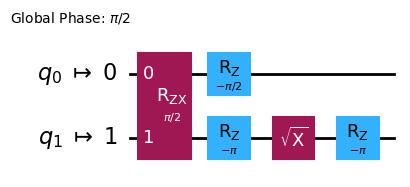

In [3]:
coupling_string = [[0, 1]]
CM = CouplingMap(coupling_string)
qc = QuantumCircuit(2)
qc.cx(0,1)

trans = transpile(qc, coupling_map=CM, basis_gates=['id', 'rz', 'sx', 'rzx']) 
trans.draw(output='mpl')